In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isratanika","key":"3a7c473846fd270574def603f8096410"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:47<00:00, 25.0MB/s]
100% 1.03G/1.03G [00:47<00:00, 23.4MB/s]


In [5]:
!unzip asl-alphabet.zip -d ./asl_dataset


Streaming output truncated to the last 5000 lines.
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: ./asl_dataset/asl_alphabet_tr

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Settings
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "./asl_dataset/asl_alphabet_train/asl_alphabet_train"

# ✅ Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% for validation
)

# ✅ Training Data Generator
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# ✅ Validation Data Generator
val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# ✅ Number of Classes
num_classes = len(train_generator.class_indices)

print(f"✅ Number of classes: {num_classes}")
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
✅ Number of classes: 29
✅ Training samples: 69600
✅ Validation samples: 17400


In [ ]:


import os
print(os.listdir(DATASET_PATH))


['W', 'nothing', 'P', 'Q', 'S', 'E', 'O', 'C', 'F', 'V', 'B', 'del', 'J', 'space', 'L', 'M', 'K', 'H', 'X', 'U', 'N', 'A', 'Z', 'T', 'D', 'R', 'G', 'Y', 'I']


In [7]:
# ✅ Convert generators to tf.data.Dataset for small batch handling
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).batch(32).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

# ✅ Enable Mixed Precision for T4 GPU Optimization
mixed_precision.set_global_policy('mixed_float16')

# ✅ Settings
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "./asl_dataset/asl_alphabet_train/asl_alphabet_train"


In [9]:
# ✅ Load Dataset and Split into Small Batches
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True
)

# ✅ Save class_names BEFORE prefetching!
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"✅ Number of classes: {num_classes}")

# ✅ Now Apply Prefetch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# ✅ Adjust Steps per Epoch (2700 total steps)
steps_per_epoch = 2700 // BATCH_SIZE
validation_steps = len(val_ds) // BATCH_SIZE


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
✅ Number of classes: 29


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

# ✅ Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Define Simplified CNN Model (Fewer CNN Layers)
model_cnn = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # ✅ First Layer
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    # ✅ Second Layer
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    # ✅ Optional Third Layer (Can be removed if needed)
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256),
    LeakyReLU(),
    Dropout(0.4),  # ✅ Prevent Overfitting

    Dense(128),
    LeakyReLU(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# ✅ Compile the Model with Lower Learning Rate
model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),  # ✅ Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Model Summary
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 29)                  │           3,7

 Total params: 25,821,149 (98.50 MB)

 Trainable params: 25,820,701 (98.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# ✅ Early Stopping to Avoid Overfitting
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# ✅ Learning Rate Scheduler (reduces LR on plateau)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# ✅ Train CNN Model
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 103s 38ms/step - accuracy: 0.2955 - loss: 3.7625 - val_accuracy: 0.6253 - val_loss: 1.2795 - learning_rate: 1.0000e-04
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - accuracy: 0.7308 - loss: 0.8666 - val_accuracy: 0.8854 - val_loss: 0.3324 - learning_rate: 1.0000e-04
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.8503 - loss: 0.4650 - val_accuracy: 0.9280 - val_loss: 0.2097 - learning_rate: 1.0000e-04
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 88s 39ms/step - accuracy: 0.8995 - loss: 0.3061 - val_accuracy: 0.9628 - val_loss: 0.1143 - learning_rate: 1.0000e-04
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 86s 40ms/step - accuracy: 0.9298 - loss: 0.2112 - val_accuracy: 0.9466 - val_loss: 0.1607 - learning_rate: 1.0000e-04
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.9480 - loss: 0.1576 - val_accuracy: 0.7826 - val_loss: 1.2658 - learning_rate: 1.0000e-04
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Define Evaluation Metrics
def compute_metrics(y_true, y_pred):
    # Ensure both are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

print("✅ Evaluation Metrics Defined!")

# ✅ Step 2: Define Custom Evaluation Function for Reduced CNN Model
class CNNReducedEvaluator:
    def __init__(self, model, val_ds):  # Fix constructor name
        self.model = model
        self.val_ds = val_ds

    def evaluate(self):
        print("\n🔍 Evaluating Reduced CNN Model...")

        y_true = []
        y_pred = []

        # ✅ Collect true and predicted labels batch-by-batch
        for images, labels in self.val_ds:
            logits = self.model.predict(images, verbose=0)

            # ✅ Extract predicted class
            predictions = np.argmax(logits, axis=-1)

            # ✅ Collect true labels and predicted labels
            y_true.extend(np.argmax(labels.numpy(), axis=-1))  # Convert one-hot to label index
            y_pred.extend(predictions)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # ✅ Compute Metrics
        metrics = compute_metrics(y_true, y_pred)

        # ✅ Print Results (Like TensorFlow Format)
        print("\n✅ FINAL MODEL RESULTS ✅")
        for key, value in metrics.items():
            print(f"{key}: {value:.5f}")

        return metrics  # Ensure the function returns metrics

# ✅ Step 3: Run Evaluation for  Reduced CNN Model
if 'model_cnn' in locals():
    evaluator = CNNReducedEvaluator(model_cnn, val_ds)
    eval_results = evaluator.evaluate()

    # ✅ Save to Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    model_cnn.save('/content/drive/MyDrive/asl_cnn_reduced.h5')
    print("✅ Reduced CNN model saved to Google Drive!")

✅ Evaluation Metrics Defined!

🔍 Evaluating Reduced CNN Model...

✅ FINAL MODEL RESULTS ✅
accuracy: 0.99299
precision: 0.99314
recall: 0.99299
f1-score: 0.99300


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Reduced CNN model saved to Google Drive!


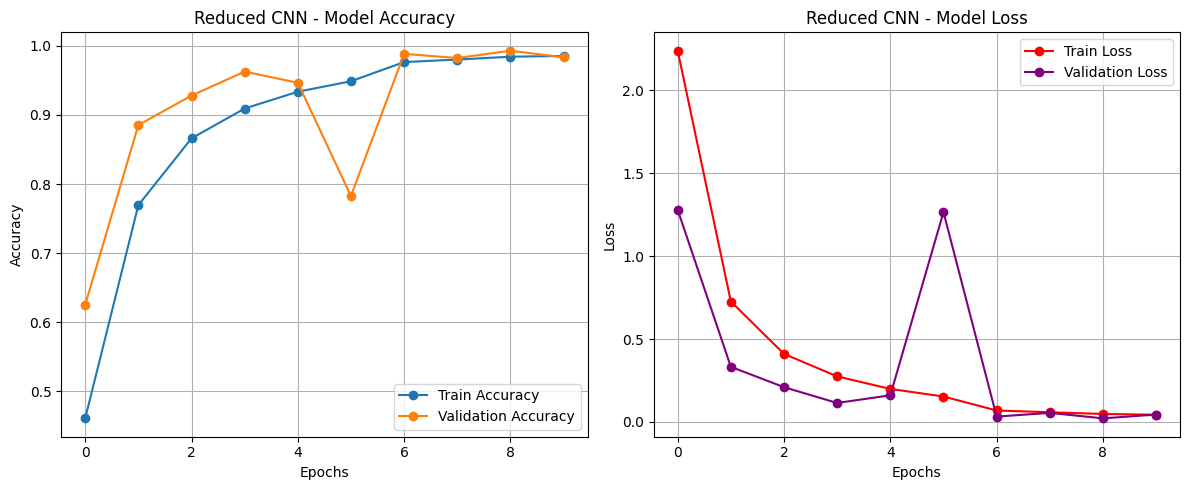

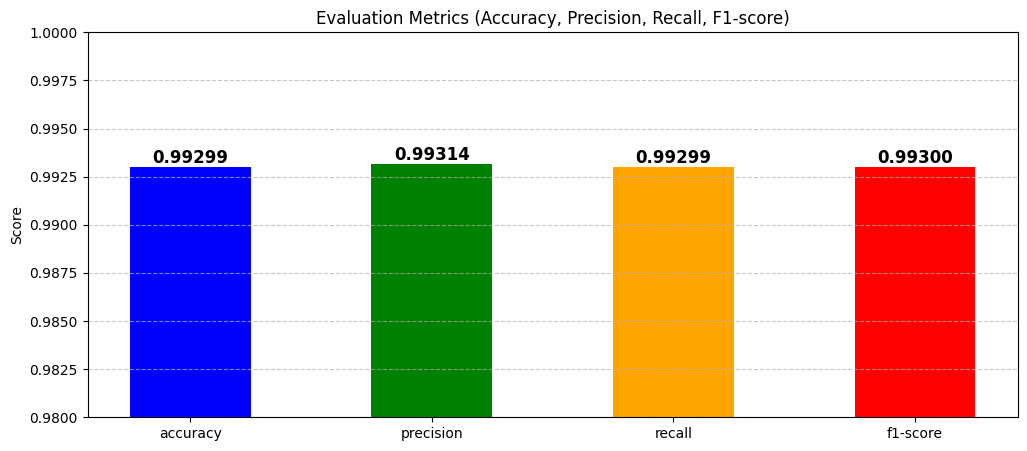

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Define evaluation metrics (from previous evaluation results)
eval_metrics = {
    "accuracy":0.99299 ,
    "precision": 0.99314,
    "recall": 0.99299,
    "f1-score": 0.99300
}

# ✅ Function to plot training accuracy & loss
def plot_training_history(history, model_name="CNN"):
    plt.figure(figsize=(12, 5))

    # ✅ Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'{model_name} - Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # ✅ Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='purple')
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Function to plot Accuracy, Precision, Recall, and F1-score side by side
def plot_eval_metrics(metrics):
    plt.figure(figsize=(12, 5))

    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    colors = ["blue", "green", "orange", "red"]

    plt.bar(metric_names, metric_values, color=colors, width=0.5)
    plt.ylabel("Score")
    plt.ylim(0.98, 1.0)  # Adjust y-axis for better visualization
    plt.title("Evaluation Metrics (Accuracy, Precision, Recall, F1-score)")

    for i, v in enumerate(metric_values):
        plt.text(i, v, f"{v:.5f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# ✅ Plot training accuracy & loss
if 'history_cnn' in locals():
    plot_training_history(history_cnn, model_name="Reduced CNN")

# ✅ Plot Accuracy, Precision, Recall & F1-score together
plot_eval_metrics(eval_metrics)